In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from scipy.stats import levene
from scipy.stats import ttest_ind
from scipy.stats import f_oneway, kruskal
from scipy.stats import chi2_contingency
from scipy.stats import skew, kurtosis
from statsmodels.graphics.gofplots import qqplot


import re
import string
import emoji
from bs4 import BeautifulSoup
from textblob import TextBlob

import nltk
nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords')


from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.porter import PorterStemmer
from collections import Counter
from wordcloud import WordCloud
import distance
from fuzzywuzzy import fuzz


import time
from tqdm.notebook import tqdm
tqdm.pandas()


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE


import xgboost as xgb
import lightgbm as lgbv

[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /Users/admin/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Loading Data & Initial Sanity Checks**

In [61]:
train_non_nlp_df = pd.read_csv('./data_post_feat_eng_fulldata/train_non_nlp.csv')
test_non_nlp_df = pd.read_csv('./data_post_feat_eng_fulldata/test_non_nlp.csv')

train_nlp_basic_df = pd.read_csv('./data_post_feat_eng_fulldata/train_nlp_basic.csv')
test_nlp_basic_df = pd.read_csv('./data_post_feat_eng_fulldata/test_nlp_basic.csv')

train_nlp_w2v_df = pd.read_csv('./data_post_feat_eng_fulldata/train_nlp_w2v.csv')
test_nlp_w2v_df = pd.read_csv('./data_post_feat_eng_fulldata/test_nlp_w2v.csv')

train_final_df = pd.read_csv('./data_post_feat_eng_fulldata/train_final.csv')
test_final_df = pd.read_csv('./data_post_feat_eng_fulldata/test_final.csv')

In [62]:
train_non_nlp_nlp_basic = pd.merge(train_non_nlp_df, train_nlp_basic_df, on='id', how='inner')
test_non_nlp_nlp_basic = pd.merge(test_non_nlp_df, test_nlp_basic_df, on='id', how='inner')

In [63]:
print(train_non_nlp_df.shape, test_non_nlp_df.shape)
print(train_nlp_basic_df.shape, test_nlp_basic_df.shape)
print(train_non_nlp_nlp_basic.shape, test_non_nlp_nlp_basic.shape)
print(train_nlp_w2v_df.shape, test_nlp_w2v_df.shape)
print(train_final_df.shape, test_final_df.shape)

(76471, 51) (32774, 51)
(76473, 62) (32775, 62)
(76471, 112) (32774, 112)
(76473, 409) (32775, 409)
(76471, 520) (32774, 520)


In [64]:
print(train_non_nlp_df.duplicated().sum())
print(test_non_nlp_df.duplicated().sum())

print(train_nlp_basic_df.duplicated().sum())
print(test_nlp_basic_df.duplicated().sum())

print(train_non_nlp_nlp_basic.duplicated().sum())
print(test_non_nlp_nlp_basic.duplicated().sum())

print(train_nlp_w2v_df.duplicated().sum())
print(test_nlp_w2v_df.duplicated().sum())

print(train_final_df.duplicated().sum())
print(test_final_df.duplicated().sum())

0
0
0
0
0
0
0
0
0
0


In [65]:
print(train_non_nlp_df.isna().sum().loc[train_non_nlp_df.isna().sum()>0])
print(test_non_nlp_df.isna().sum().loc[test_non_nlp_df.isna().sum()>0])

print(train_nlp_basic_df.isna().sum().loc[train_nlp_basic_df.isna().sum()>0])
print(test_nlp_basic_df.isna().sum().loc[test_nlp_basic_df.isna().sum()>0])

print(train_non_nlp_nlp_basic.isna().sum().loc[train_non_nlp_nlp_basic.isna().sum()>0])
print(test_non_nlp_nlp_basic.isna().sum().loc[test_non_nlp_nlp_basic.isna().sum()>0])

print(train_nlp_w2v_df.isna().sum().loc[train_nlp_w2v_df.isna().sum()>0])
print(test_nlp_w2v_df.isna().sum().loc[test_nlp_w2v_df.isna().sum()>0])

print(train_final_df.isna().sum().loc[train_final_df.isna().sum()>0])
print(test_final_df.isna().sum().loc[test_final_df.isna().sum()>0])

Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)


# **Finding categorical columns**

In [66]:
def split_cols(df):
    
    cat_cols = []
    num_cols = []
    other_cols = []

    for col in df.columns:
        if df[col].dtype=='object':
            cat_cols.append(col)
        elif df[col].dtype=='int' or df[col].dtype=='float':
            num_cols.append(col)
        else:
            other_cols.append(col)

    print(f'Categorical columns length: {len(cat_cols)}')
    print(f'Numerical columns length: {len(num_cols)}')
    print(f'Other columns length: {len(other_cols)}')
    
    return cat_cols, num_cols, other_cols

cat_cols, num_cols, other_cols = split_cols(train_final_df)
print(cat_cols)

Categorical columns length: 6
Numerical columns length: 514
Other columns length: 0
['id', 'teacher_prefix', 'school_state', 'project_grade_category', 'records_per_user_cat', 'res_exp_item_qcat']


# **Sampling from the data**

In [67]:
train_non_nlp_df_samp = train_non_nlp_df.sample(frac=0.4, random_state=42)
test_non_nlp_df_samp = test_non_nlp_df.sample(frac=0.4, random_state=42)

train_non_nlp_nlp_basic_samp = train_non_nlp_nlp_basic.sample(frac=0.4, random_state=42)
test_non_nlp_nlp_basic_samp = test_non_nlp_nlp_basic.sample(frac=0.4, random_state=42)

train_final_df_samp = train_final_df.sample(frac=0.4, random_state=42)
test_final_df_samp = test_final_df.sample(frac=0.4, random_state=42)

# **Helper Functions**

In [68]:
def dep_ind_feat_split(df_train, df_test):
    
    X_train = df_train.drop(['id', 'project_is_approved'], axis=1)
    y_train = df_train['project_is_approved']
    
    X_test = df_test.drop(['id', 'project_is_approved'], axis=1)
    y_test = df_test['project_is_approved']
    
    print('Train shape:', X_train.shape, y_train.shape)
    print('Test shape:', X_test.shape, y_test.shape)
    print('-'*50)
    
    return X_train, y_train, X_test, y_test

In [1]:
def cat_to_num(X_train_inp, y_train, X_test_inp, y_test):
    

    tar_enc_cols = ['teacher_prefix', 'school_state', 'project_grade_category', 'res_exp_item_qcat']
    lab_enc_cols = ['records_per_user_cat']
    
    X_train = X_train_inp.copy()
    X_test = X_test_inp.copy()
    
    print('Pre Cat2Num Transformation')
    cat_cols, num_cols, other_cols = split_cols(X_train)
    print('-'*50)
    
    
    tar_enc_dict = {}
    for col in tar_enc_cols:
        tar_enc_dict[col] = TargetEncoder()
        X_train[col] = tar_enc_dict[col].fit_transform(X_train[col], y_train)
        X_test[col] = tar_enc_dict[col].transform(X_test[col])
        
    lab_enc_dict = {}
    for col in lab_enc_cols:
        lab_enc_dict[col] = LabelEncoder()
        X_train[col] = lab_enc_dict[col].fit_transform(X_train[col])
        X_test[col] = lab_enc_dict[col].transform(X_test[col])
        
    print('Post Cat2Num Transformation')
    cat_cols, num_cols, other_cols = split_cols(X_train)
    print('-'*50)
        
    return X_train, X_test

In [70]:
def feat_scale(X_train, X_test):
    
    std_scaler = StandardScaler()
    X_train_scl = std_scaler.fit_transform(X_train)
    X_test_scl = std_scaler.transform(X_test)
    
    print('Feature Scaling Done')
    cat_cols, num_cols, other_cols = split_cols(X_train)
    print('-'*50)
    
    return X_train_scl, X_test_scl

In [71]:
def preprocess_pipe(df_train, df_test):
    
    X_train, y_train, X_test, y_test = dep_ind_feat_split(df_train, df_test)
    X_train_c2n, X_test_c2n = cat_to_num(X_train, y_train, X_test, y_test)
    X_train_scl, X_test_scl = feat_scale(X_train_c2n, X_test_c2n)
    
    return X_train_c2n, y_train, X_test_c2n, y_test, X_train_scl, X_test_scl

In [72]:
def get_cross_val_score_summary(model, X_train, y_train, cv=5, scoring='accuracy'):
    
    cross_val = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
    print('-'*70)
    print(f'Cross validation Score Summary: #Folds:{cv}, Score:{scoring}')
    print('-'*70)
    print(pd.Series(cross_val).describe())

    
def get_classification_report(model, df_train, X_train, y_train, X_test, y_test):
    
    # Fitting model
    model.fit(X_train, y_train)
    print('Fitting model completed!')
    
    # Generate model metrics
    print('-'*70)
    print(f'Classification Report: Model:{type(model).__name__}')
    print('-'*70)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, -1]
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    roc_auc = roc_auc_score(y_test, y_proba)

    precision_0 = precision_score(y_test, y_pred, pos_label=0)
    recall_0 = recall_score(y_test, y_pred, pos_label=0)
    f1_0 = f1_score(y_test, y_pred, pos_label=0)
    precision_1 = precision_score(y_test, y_pred, pos_label=1)
    recall_1 = recall_score(y_test, y_pred, pos_label=1)
    f1_1 = f1_score(y_test, y_pred, pos_label=1)
    
    metrics_arr = np.array([train_acc, test_acc, roc_auc, precision_0, recall_0, f1_0, precision_1, recall_1, f1_1])
    
    
    print("Train accuracy:", train_acc)
    print("Test accuracy:", test_acc)
    print("ROC-AUC score: ", roc_auc)
    print('-'*50)
    print(classification_report(y_test, y_pred))
    print('-'*50)
    print('Confusion Matrix on Test Set:')
    print(confusion_matrix(y_test, y_pred))
    print('-'*50)
    
    
    # Get feature importances
    ser_feat_imp= pd.Series(dict(zip(df_train.columns, model.feature_importances_))).sort_values(ascending=False)
    print('Top-10 important features:')
    print(ser_feat_imp.iloc[:10])
    print('-'*50)
    
    # Plot feature importances (Top-k)
    k = 25
    plt.figure(figsize=(20, 4))
    plt.bar(ser_feat_imp.iloc[:k].index, ser_feat_imp.iloc[:k].values)
    plt.xticks(rotation=90)
    plt.show()
    
    return metrics_arr

In [73]:
def balance_target(X_train_scl, y_train):
    
    sm = SMOTE(random_state = 42)
    X_train_scl_smote, y_train_smote = sm.fit_resample(X_train_scl, y_train)
    
    return X_train_scl_smote, y_train_smote

# **Feature Set1: Non-NLP**

## **Imbalanced Target**

In [74]:
X1_train, y1_train, X1_test, y1_test, X1_train_scl, X1_test_scl = preprocess_pipe(train_non_nlp_df_samp, test_non_nlp_df_samp)

Train shape: (30588, 49) (30588,)
Test shape: (13110, 49) (13110,)
--------------------------------------------------
Pre Cat2Num Transformation
Categorical columns length: 5
Numerical columns length: 44
Other columns length: 0
--------------------------------------------------
Post Cat2Num Transformation
Categorical columns length: 0
Numerical columns length: 49
Other columns length: 0
--------------------------------------------------
Feature Scaling Done
Categorical columns length: 0
Numerical columns length: 49
Other columns length: 0
--------------------------------------------------


In [75]:
y1_train.value_counts()

1    26004
0     4584
Name: project_is_approved, dtype: int64

### **Iteration1: RF Classifier**

In [76]:
rfc1 = RandomForestClassifier(random_state=42)
# get_cross_val_score_summary(model=rfc1, 
#                             X_train=X1_train_scl, 
#                             y_train=y1_train, 
#                             cv=5, 
#                             scoring='accuracy')

Fitting model completed!
----------------------------------------------------------------------
Classification Report: Model:RandomForestClassifier
----------------------------------------------------------------------
Train accuracy: 1.0
Test accuracy: 0.8452326468344775
ROC-AUC score:  0.6679220264279206
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.31      0.01      0.02      2006
           1       0.85      1.00      0.92     11104

    accuracy                           0.85     13110
   macro avg       0.58      0.50      0.47     13110
weighted avg       0.77      0.85      0.78     13110

--------------------------------------------------
Confusion Matrix on Test Set:
[[   19  1987]
 [   42 11062]]
--------------------------------------------------
Top-10 important features:
res_price_ln                                    0.123670
res_item_uniq_q_ln                              0.099293
res_item_q

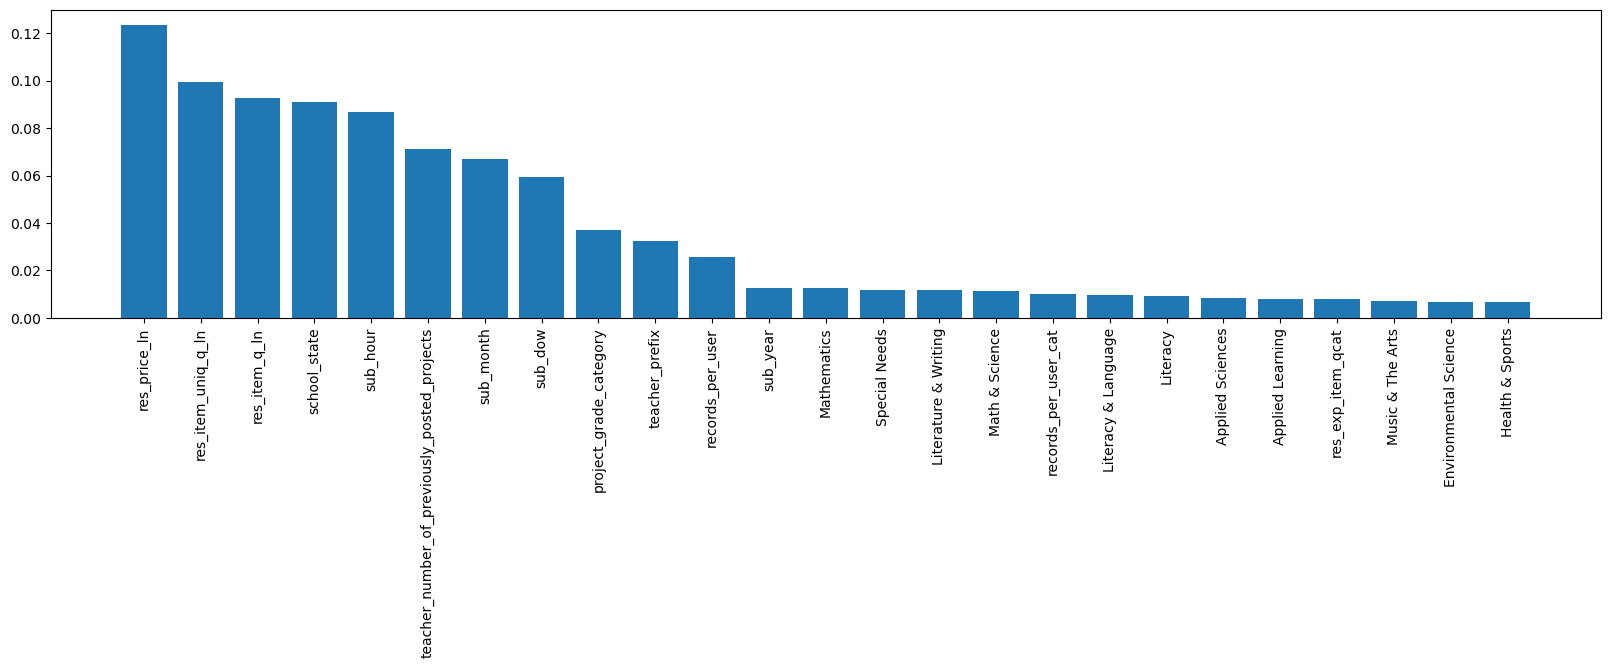

In [77]:
iter1_metrics_arr = get_classification_report(model=rfc1, 
                                              df_train=X1_train, 
                                              X_train=X1_train_scl, 
                                              y_train=y1_train, 
                                              X_test=X1_test_scl, 
                                              y_test=y1_test)

### **Iteration2: XGB Classifier**

In [78]:
xgbc2 = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
# get_cross_val_score_summary(model=xgbc2, 
#                             X_train=X1_train_scl, 
#                             y_train=y1_train, 
#                             cv=5, 
#                             scoring='accuracy')

Fitting model completed!
----------------------------------------------------------------------
Classification Report: Model:XGBClassifier
----------------------------------------------------------------------
Train accuracy: 0.8839087223747875
Test accuracy: 0.840045766590389
ROC-AUC score:  0.66867047901684
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.33      0.04      0.08      2006
           1       0.85      0.98      0.91     11104

    accuracy                           0.84     13110
   macro avg       0.59      0.51      0.49     13110
weighted avg       0.77      0.84      0.78     13110

--------------------------------------------------
Confusion Matrix on Test Set:
[[   88  1918]
 [  179 10925]]
--------------------------------------------------
Top-10 important features:
res_item_uniq_q_ln                              0.062371
Literacy                                        0.031089
Social 

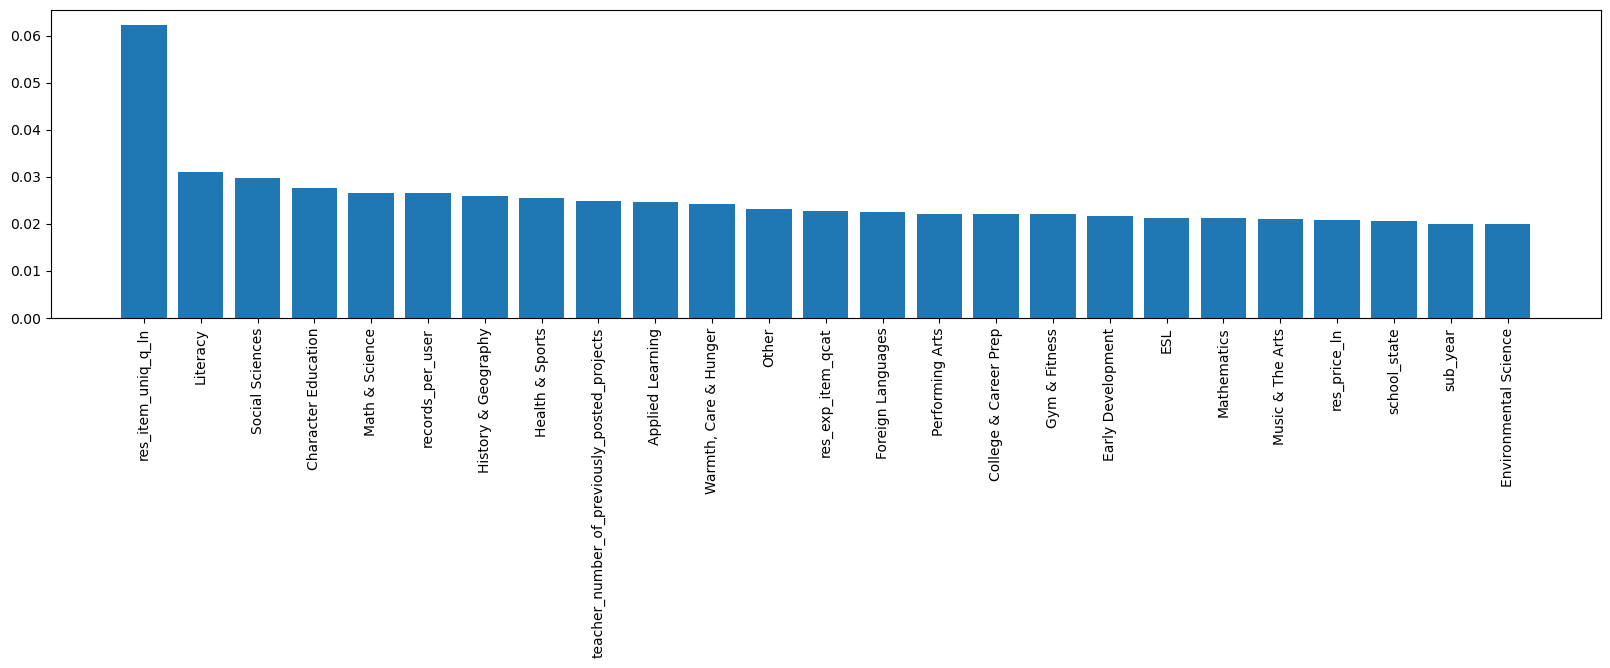

In [79]:
iter2_metrics_arr = get_classification_report(model=xgbc2, 
                                              df_train=X1_train, 
                                              X_train=X1_train_scl, 
                                              y_train=y1_train, 
                                              X_test=X1_test_scl, 
                                              y_test=y1_test)

## **Balanced Target**

In [80]:
y1_train.value_counts()

1    26004
0     4584
Name: project_is_approved, dtype: int64

In [81]:
X1_train_scl_smote, y1_train_smote = balance_target(X_train_scl=X1_train_scl, 
                                                    y_train=y1_train)

In [82]:
y1_train_smote.value_counts()

1    26004
0    26004
Name: project_is_approved, dtype: int64

### **Iteration3: RF Classifier**

In [83]:
rfc3 = RandomForestClassifier(random_state=42)
# get_cross_val_score_summary(model=rfc3, 
#                             X_train=X1_train_scl_smote, 
#                             y_train=y1_train_smote, 
#                             cv=5, 
#                             scoring='accuracy')

Fitting model completed!
----------------------------------------------------------------------
Classification Report: Model:RandomForestClassifier
----------------------------------------------------------------------
Train accuracy: 1.0
Test accuracy: 0.8308924485125858
ROC-AUC score:  0.6611097677787962
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.28      0.07      0.11      2006
           1       0.85      0.97      0.91     11104

    accuracy                           0.83     13110
   macro avg       0.57      0.52      0.51     13110
weighted avg       0.77      0.83      0.78     13110

--------------------------------------------------
Confusion Matrix on Test Set:
[[  138  1868]
 [  349 10755]]
--------------------------------------------------
Top-10 important features:
res_item_uniq_q_ln                              0.174233
project_grade_category                          0.093964
res_item_q

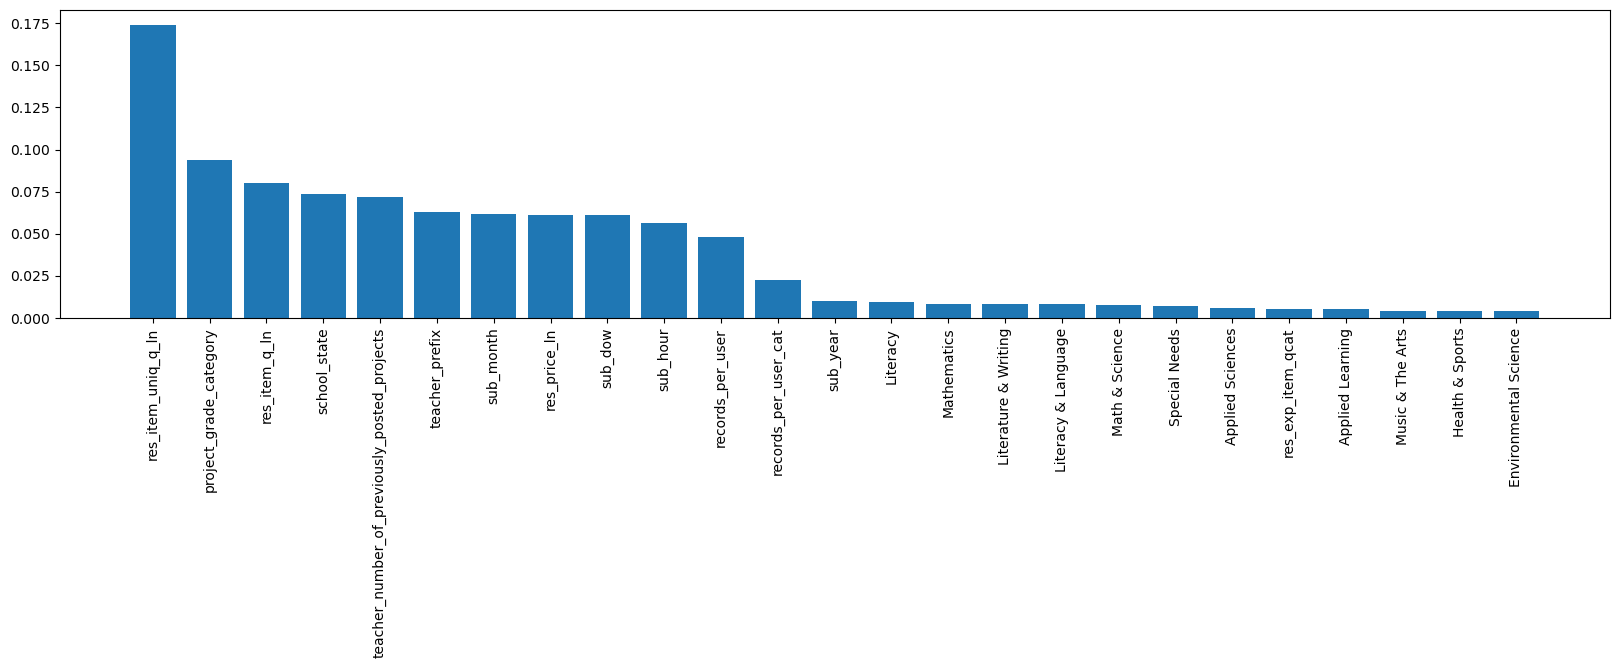

In [84]:
iter3_metrics_arr = get_classification_report(model=rfc3, 
                                              df_train=X1_train, 
                                              X_train=X1_train_scl_smote, 
                                              y_train=y1_train_smote, 
                                              X_test=X1_test_scl, 
                                              y_test=y1_test)

### **Iteration4: XGB Classifier**

In [85]:
xgbc4 = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
# get_cross_val_score_summary(model=xgbc4, 
#                             X_train=X1_train_scl_smote, 
#                             y_train=y1_train_smote, 
#                             cv=5, 
#                             scoring='accuracy')

Fitting model completed!
----------------------------------------------------------------------
Classification Report: Model:XGBClassifier
----------------------------------------------------------------------
Train accuracy: 0.9257229656975849
Test accuracy: 0.841723874904653
ROC-AUC score:  0.6751499598826001
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.35      0.04      0.07      2006
           1       0.85      0.99      0.91     11104

    accuracy                           0.84     13110
   macro avg       0.60      0.51      0.49     13110
weighted avg       0.77      0.84      0.78     13110

--------------------------------------------------
Confusion Matrix on Test Set:
[[   77  1929]
 [  146 10958]]
--------------------------------------------------
Top-10 important features:
res_item_uniq_q_ln                              0.151127
project_grade_category                          0.118796
recor

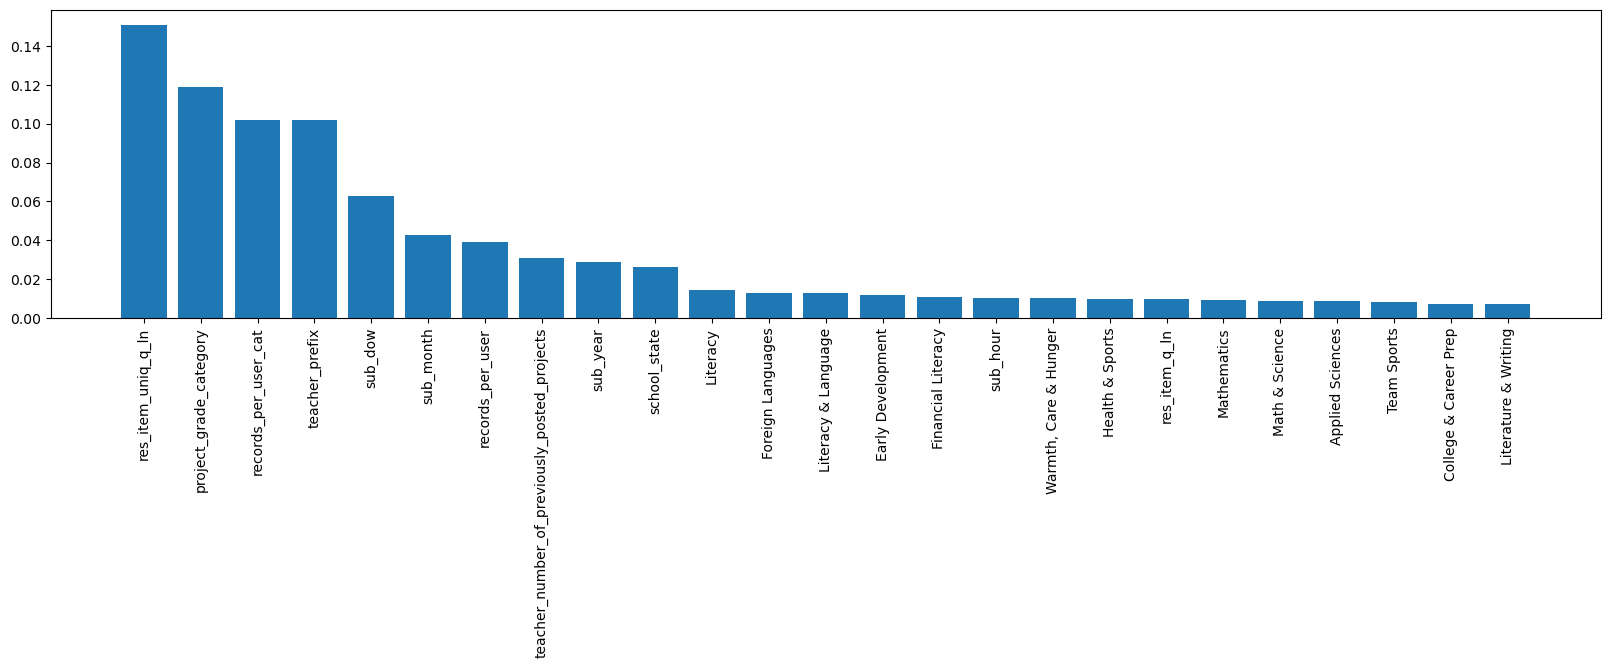

In [86]:
iter4_metrics_arr = get_classification_report(model=xgbc4, 
                                              df_train=X1_train, 
                                              X_train=X1_train_scl_smote, 
                                              y_train=y1_train_smote, 
                                              X_test=X1_test_scl, 
                                              y_test=y1_test)

# **Feature Set2: Non-NLP + NLP-Baisc**

In [87]:
X2_train, y2_train, X2_test, y2_test, X2_train_scl, X2_test_scl = preprocess_pipe(train_non_nlp_nlp_basic_samp, 
                                                                                  test_non_nlp_nlp_basic_samp)

Train shape: (30588, 110) (30588,)
Test shape: (13110, 110) (13110,)
--------------------------------------------------
Pre Cat2Num Transformation
Categorical columns length: 5
Numerical columns length: 105
Other columns length: 0
--------------------------------------------------
Post Cat2Num Transformation
Categorical columns length: 0
Numerical columns length: 110
Other columns length: 0
--------------------------------------------------
Feature Scaling Done
Categorical columns length: 0
Numerical columns length: 110
Other columns length: 0
--------------------------------------------------


## **Imbalanced Target**

### **Iteration 5: RF Classifier**

In [88]:
rfc5 = RandomForestClassifier(random_state=42)
# get_cross_val_score_summary(model=rfc5, 
#                             X_train=X2_train_scl, 
#                             y_train=y2_train, 
#                             cv=5, 
#                             scoring='accuracy')

Fitting model completed!
----------------------------------------------------------------------
Classification Report: Model:RandomForestClassifier
----------------------------------------------------------------------
Train accuracy: 1.0
Test accuracy: 0.8489702517162472
ROC-AUC score:  0.7147460266893843
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.54      0.08      0.14      2006
           1       0.86      0.99      0.92     11104

    accuracy                           0.85     13110
   macro avg       0.70      0.53      0.53     13110
weighted avg       0.81      0.85      0.80     13110

--------------------------------------------------
Confusion Matrix on Test Set:
[[  162  1844]
 [  136 10968]]
--------------------------------------------------
Top-10 important features:
ess2_rej_scr             0.066696
res_sum_rej_scr          0.040544
res_item_uniq_q_ln       0.032509
ess1_rej_scr          

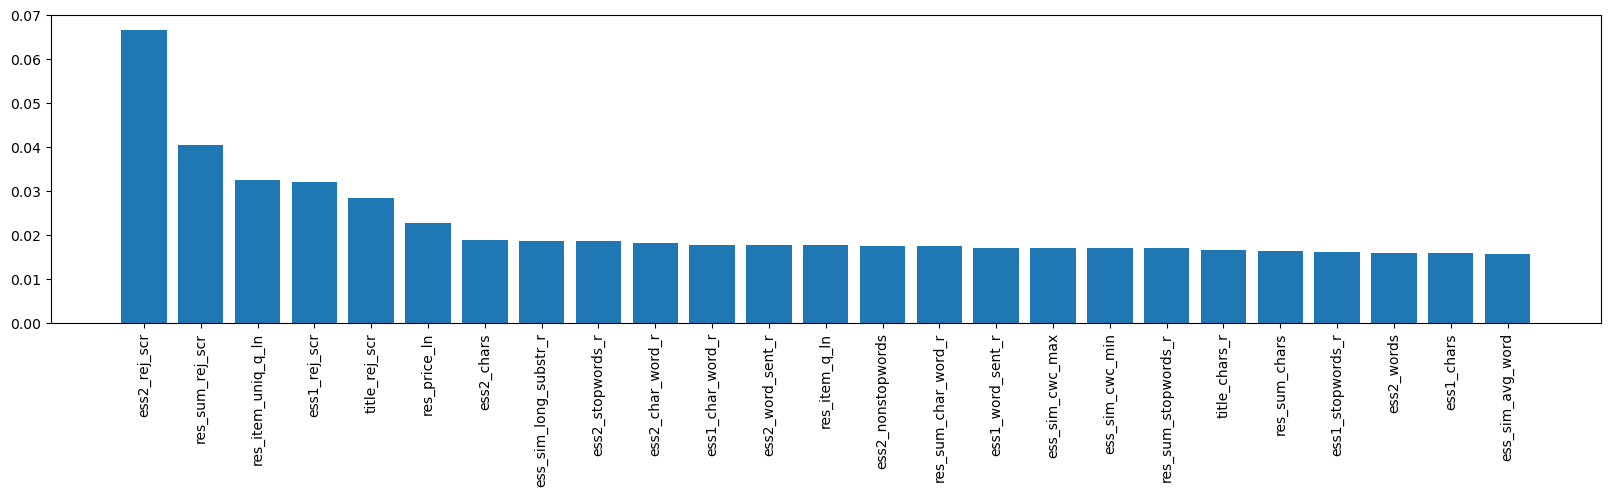

In [89]:
iter5_metrics_arr = get_classification_report(model=rfc5, 
                                              df_train=X2_train, 
                                              X_train=X2_train_scl, 
                                              y_train=y2_train, 
                                              X_test=X2_test_scl, 
                                              y_test=y2_test)

### **Iteration 6: XGB Classifier**

In [90]:
xgbc6 = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
# get_cross_val_score_summary(model=xgbc6, 
#                             X_train=X2_train_scl, 
#                             y_train=y2_train, 
#                             cv=5, 
#                             scoring='accuracy')

Fitting model completed!
----------------------------------------------------------------------
Classification Report: Model:XGBClassifier
----------------------------------------------------------------------
Train accuracy: 0.9441938014907807
Test accuracy: 0.8395881006864988
ROC-AUC score:  0.7102811477311581
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.44      0.17      0.25      2006
           1       0.87      0.96      0.91     11104

    accuracy                           0.84     13110
   macro avg       0.65      0.57      0.58     13110
weighted avg       0.80      0.84      0.81     13110

--------------------------------------------------
Confusion Matrix on Test Set:
[[  343  1663]
 [  440 10664]]
--------------------------------------------------
Top-10 important features:
ess2_rej_scr            0.056312
res_item_uniq_q_ln      0.032543
ess2_nonstopwords       0.022716
title_rej_scr      

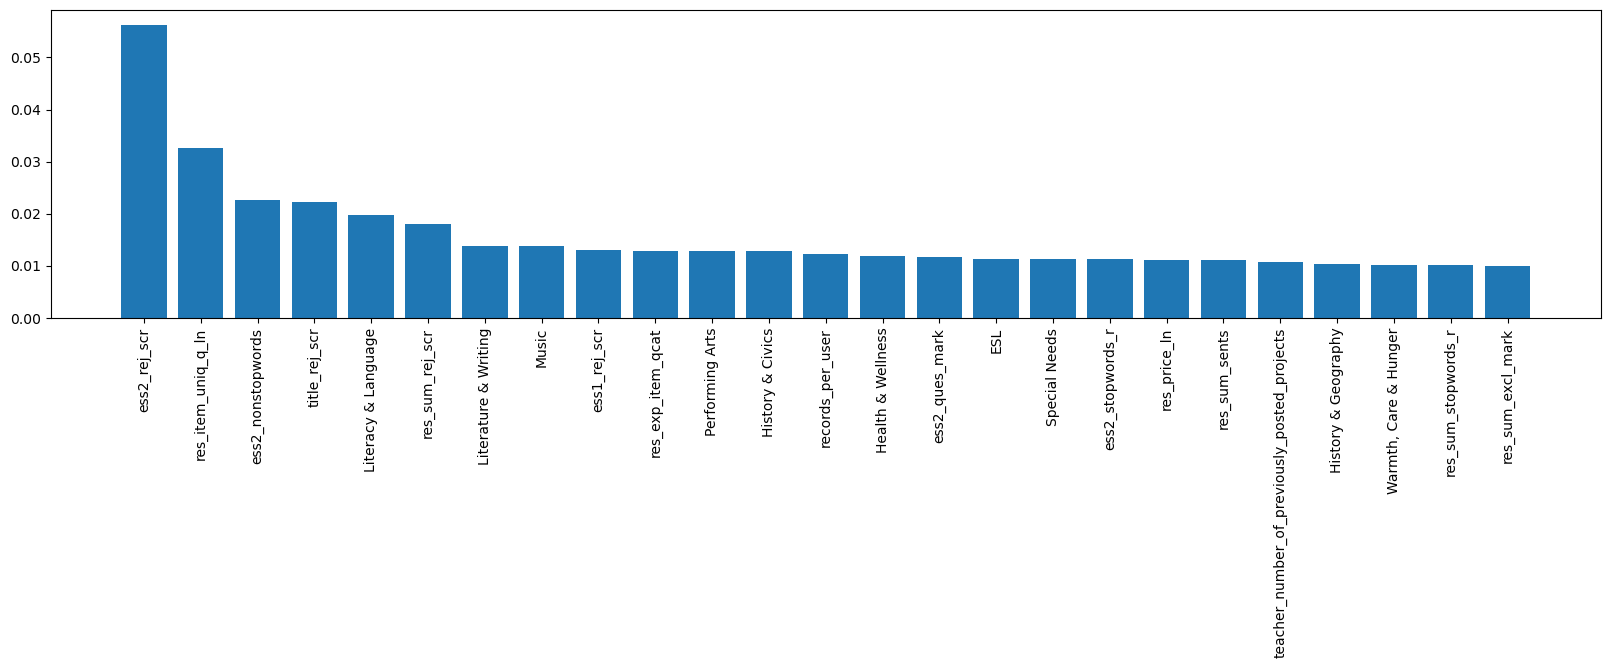

In [91]:
iter6_metrics_arr = get_classification_report(model=xgbc6, 
                                              df_train=X2_train, 
                                              X_train=X2_train_scl, 
                                              y_train=y2_train, 
                                              X_test=X2_test_scl, 
                                              y_test=y2_test)

## **Balanced Target**

In [92]:
y2_train.value_counts()

1    26004
0     4584
Name: project_is_approved, dtype: int64

In [93]:
X2_train_scl_smote, y2_train_smote = balance_target(X_train_scl=X2_train_scl, 
                                                    y_train=y2_train)

In [94]:
y2_train_smote.value_counts()

1    26004
0    26004
Name: project_is_approved, dtype: int64

### **Iteration 7: RF Classifier**

In [95]:
rfc7 = RandomForestClassifier(random_state=42)
# get_cross_val_score_summary(model=rfc7, 
#                             X_train=X2_train_scl_smote, 
#                             y_train=y2_train_smote, 
#                             cv=5, 
#                             scoring='accuracy')

Fitting model completed!
----------------------------------------------------------------------
Classification Report: Model:RandomForestClassifier
----------------------------------------------------------------------
Train accuracy: 1.0
Test accuracy: 0.8344774980930587
ROC-AUC score:  0.7210631030180353
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.42      0.23      0.29      2006
           1       0.87      0.94      0.91     11104

    accuracy                           0.83     13110
   macro avg       0.65      0.59      0.60     13110
weighted avg       0.80      0.83      0.81     13110

--------------------------------------------------
Confusion Matrix on Test Set:
[[  453  1553]
 [  617 10487]]
--------------------------------------------------
Top-10 important features:
res_item_uniq_q_ln        0.088167
ess2_rej_scr              0.061097
title_rej_scr             0.055313
res_sum_rej_scr    

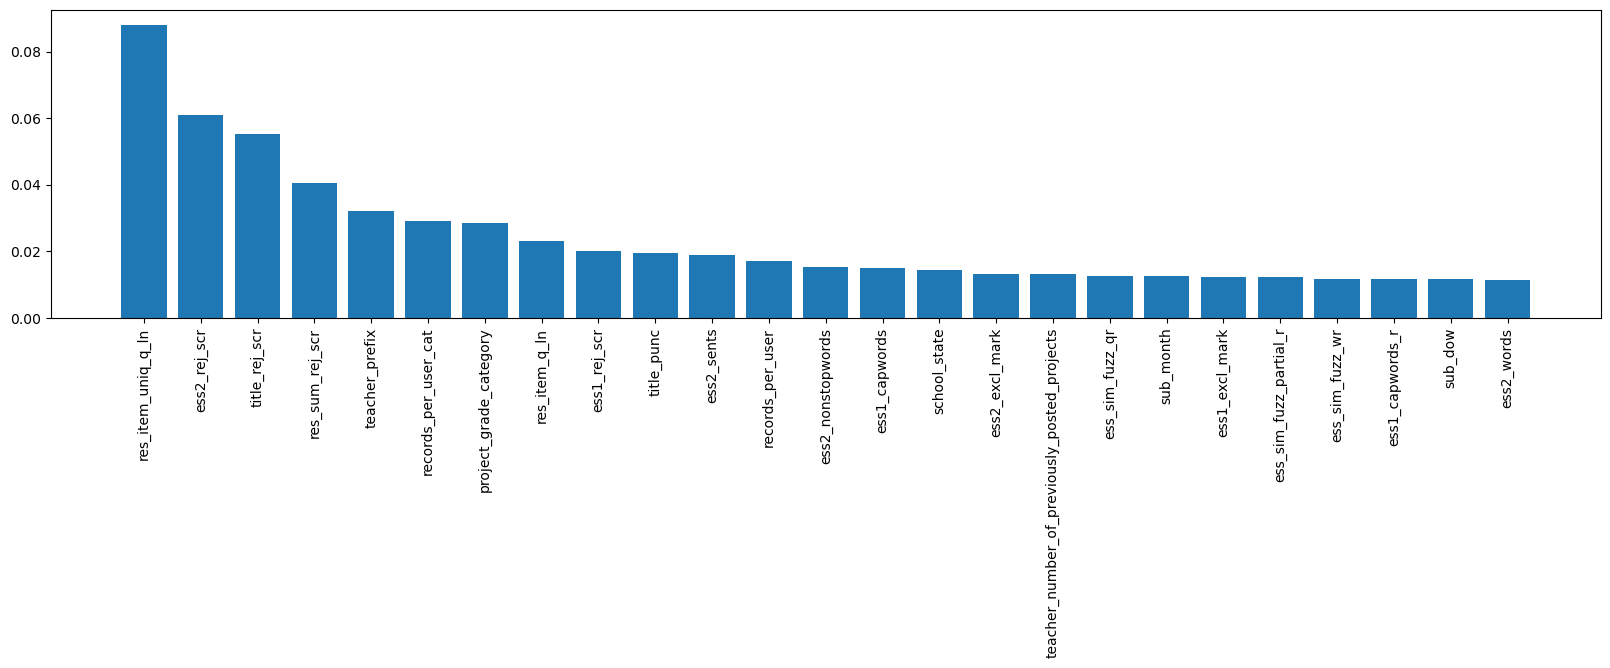

In [96]:
iter7_metrics_arr = get_classification_report(model=rfc7, 
                                              df_train=X2_train, 
                                              X_train=X2_train_scl_smote, 
                                              y_train=y2_train_smote, 
                                              X_test=X2_test_scl, 
                                              y_test=y2_test)

### **Iteration 8: XGB Classifier**

In [97]:
xgbc8 = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
# get_cross_val_score_summary(model=xgbc8, 
#                             X_train=X2_train_scl_smote, 
#                             y_train=y2_train_smote, 
#                             cv=5, 
#                             scoring='accuracy')

Fitting model completed!
----------------------------------------------------------------------
Classification Report: Model:XGBClassifier
----------------------------------------------------------------------
Train accuracy: 0.963467158898631
Test accuracy: 0.8386727688787186
ROC-AUC score:  0.7049761648052959
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.43      0.18      0.25      2006
           1       0.87      0.96      0.91     11104

    accuracy                           0.84     13110
   macro avg       0.65      0.57      0.58     13110
weighted avg       0.80      0.84      0.81     13110

--------------------------------------------------
Confusion Matrix on Test Set:
[[  361  1645]
 [  470 10634]]
--------------------------------------------------
Top-10 important features:
records_per_user_cat      0.109542
res_item_uniq_q_ln        0.105608
teacher_prefix            0.083572
title_punc    

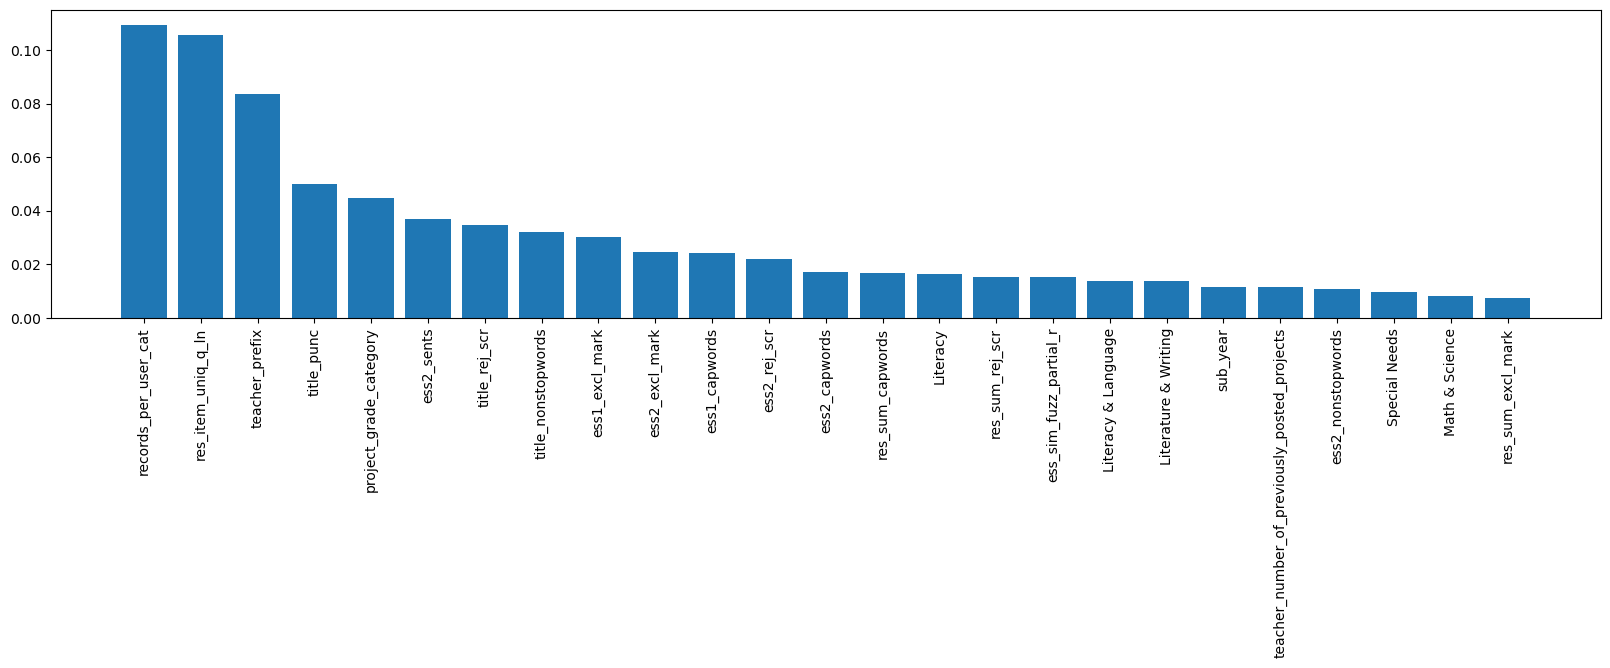

In [98]:
iter8_metrics_arr = get_classification_report(model=xgbc8, 
                                              df_train=X2_train, 
                                              X_train=X2_train_scl_smote, 
                                              y_train=y2_train_smote, 
                                              X_test=X2_test_scl, 
                                              y_test=y2_test)

# **Feature Set3: Non-NLP + NLP-Basic + NLP-W2V**

In [99]:
X3_train, y3_train, X3_test, y3_test, X3_train_scl, X3_test_scl = preprocess_pipe(train_final_df_samp, 
                                                                                  test_final_df_samp)

Train shape: (30588, 518) (30588,)
Test shape: (13110, 518) (13110,)
--------------------------------------------------
Pre Cat2Num Transformation
Categorical columns length: 5
Numerical columns length: 513
Other columns length: 0
--------------------------------------------------
Post Cat2Num Transformation
Categorical columns length: 0
Numerical columns length: 518
Other columns length: 0
--------------------------------------------------
Feature Scaling Done
Categorical columns length: 0
Numerical columns length: 518
Other columns length: 0
--------------------------------------------------


## **Imbalanced Target**

### **Iteration 9: RF Classifier**

In [100]:
rfc9 = RandomForestClassifier(random_state=42)
# get_cross_val_score_summary(model=rfc9, 
#                             X_train=X3_train_scl, 
#                             y_train=y3_train, 
#                             cv=5, 
#                             scoring='accuracy')

Fitting model completed!
----------------------------------------------------------------------
Classification Report: Model:RandomForestClassifier
----------------------------------------------------------------------
Train accuracy: 1.0
Test accuracy: 0.8493516399694889
ROC-AUC score:  0.7029702274660168
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.03      0.05      2006
           1       0.85      1.00      0.92     11104

    accuracy                           0.85     13110
   macro avg       0.78      0.51      0.48     13110
weighted avg       0.83      0.85      0.79     13110

--------------------------------------------------
Confusion Matrix on Test Set:
[[   52  1954]
 [   21 11083]]
--------------------------------------------------
Top-10 important features:
ess2_rej_scr          0.026710
res_sum_rej_scr       0.014439
res_item_uniq_q_ln    0.013561
title_rej_scr         0.013298


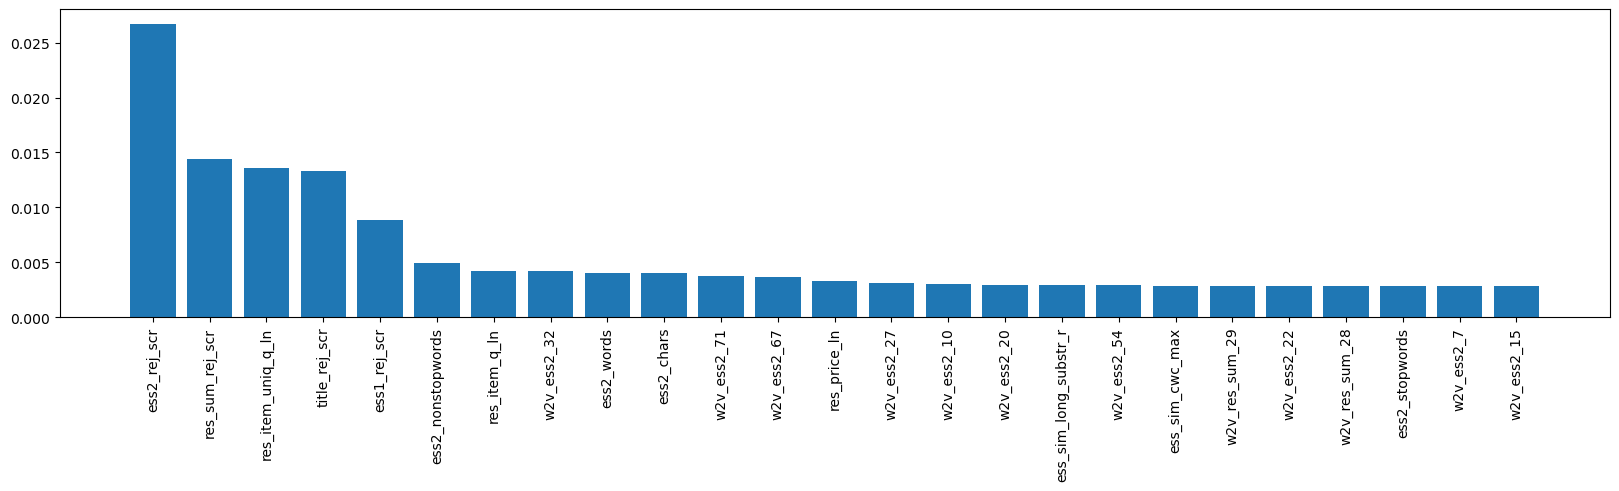

In [101]:
iter9_metrics_arr = get_classification_report(model=rfc9, 
                                              df_train=X3_train, 
                                              X_train=X3_train_scl, 
                                              y_train=y3_train, 
                                              X_test=X3_test_scl, 
                                              y_test=y3_test)

### **Iteration 10: XGB Classifier**

In [102]:
xgbc10 = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
# get_cross_val_score_summary(model=xgbc10, 
#                             X_train=X3_train_scl, 
#                             y_train=y3_train, 
#                             cv=5, 
#                             scoring='accuracy')

Fitting model completed!
----------------------------------------------------------------------
Classification Report: Model:XGBClassifier
----------------------------------------------------------------------
Train accuracy: 0.994834575650582
Test accuracy: 0.8414187643020595
ROC-AUC score:  0.7164606459799276
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.45      0.16      0.23      2006
           1       0.86      0.96      0.91     11104

    accuracy                           0.84     13110
   macro avg       0.66      0.56      0.57     13110
weighted avg       0.80      0.84      0.81     13110

--------------------------------------------------
Confusion Matrix on Test Set:
[[  319  1687]
 [  392 10712]]
--------------------------------------------------
Top-10 important features:
ess2_rej_scr                                    0.019862
res_item_uniq_q_ln                              0.010870
ess2_

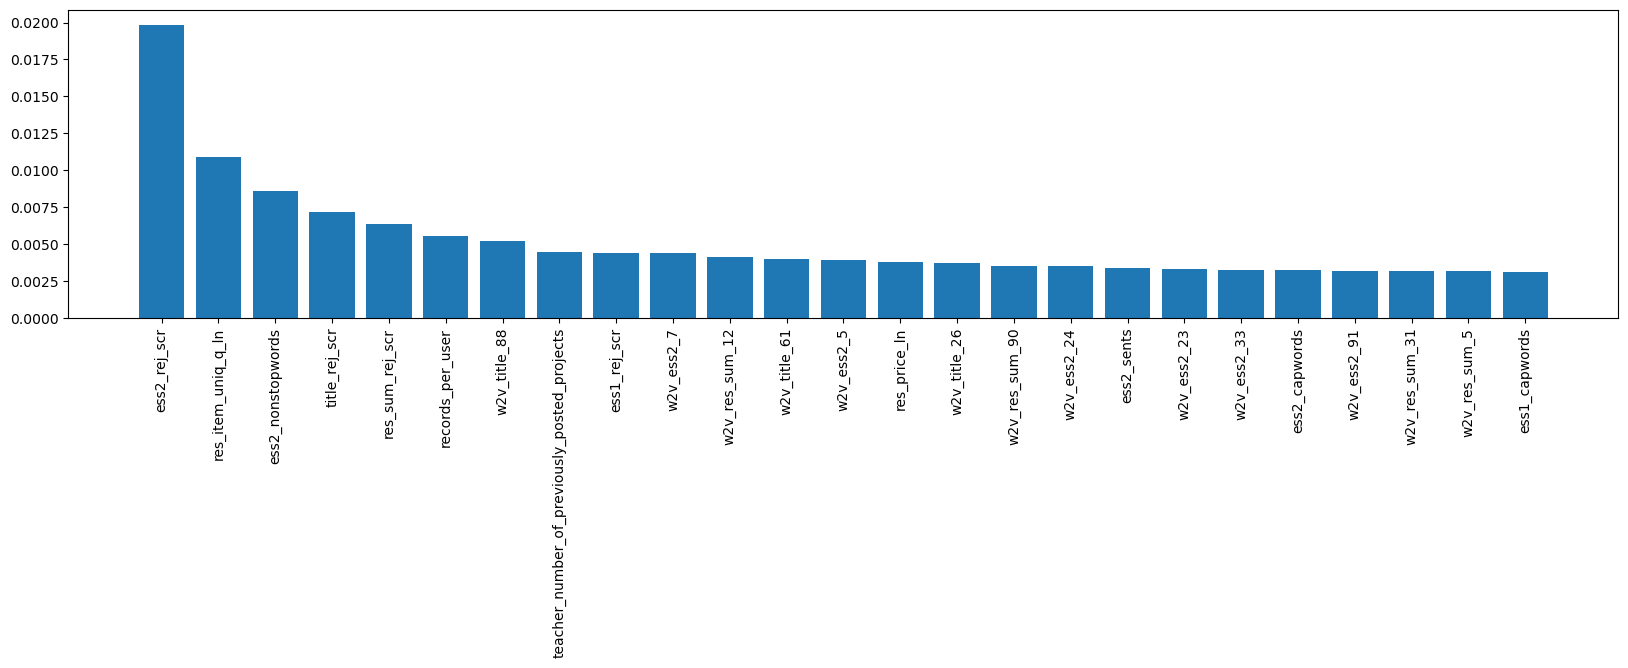

In [103]:
iter10_metrics_arr = get_classification_report(model=xgbc10, 
                                               df_train=X3_train, 
                                               X_train=X3_train_scl, 
                                               y_train=y3_train, 
                                               X_test=X3_test_scl, 
                                               y_test=y3_test)

## **Balanced Target**

In [104]:
y3_train.value_counts()

1    26004
0     4584
Name: project_is_approved, dtype: int64

In [105]:
X3_train_scl_smote, y3_train_smote = balance_target(X_train_scl=X3_train_scl, 
                                                    y_train=y3_train)

In [106]:
y3_train_smote.value_counts()

1    26004
0    26004
Name: project_is_approved, dtype: int64

### **Iteration 11: RF Classifier**

In [107]:
rfc11 = RandomForestClassifier(random_state=42)
# get_cross_val_score_summary(model=rfc11, 
#                             X_train=X3_train_scl_smote, 
#                             y_train=y3_train_smote, 
#                             cv=5, 
#                             scoring='accuracy')

Fitting model completed!
----------------------------------------------------------------------
Classification Report: Model:RandomForestClassifier
----------------------------------------------------------------------
Train accuracy: 1.0
Test accuracy: 0.8406559877955759
ROC-AUC score:  0.7133954763950224
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.45      0.17      0.25      2006
           1       0.87      0.96      0.91     11104

    accuracy                           0.84     13110
   macro avg       0.66      0.57      0.58     13110
weighted avg       0.80      0.84      0.81     13110

--------------------------------------------------
Confusion Matrix on Test Set:
[[  342  1664]
 [  425 10679]]
--------------------------------------------------
Top-10 important features:
res_item_uniq_q_ln        0.038834
ess2_rej_scr              0.034616
title_rej_scr             0.032560
records_per_user_ca

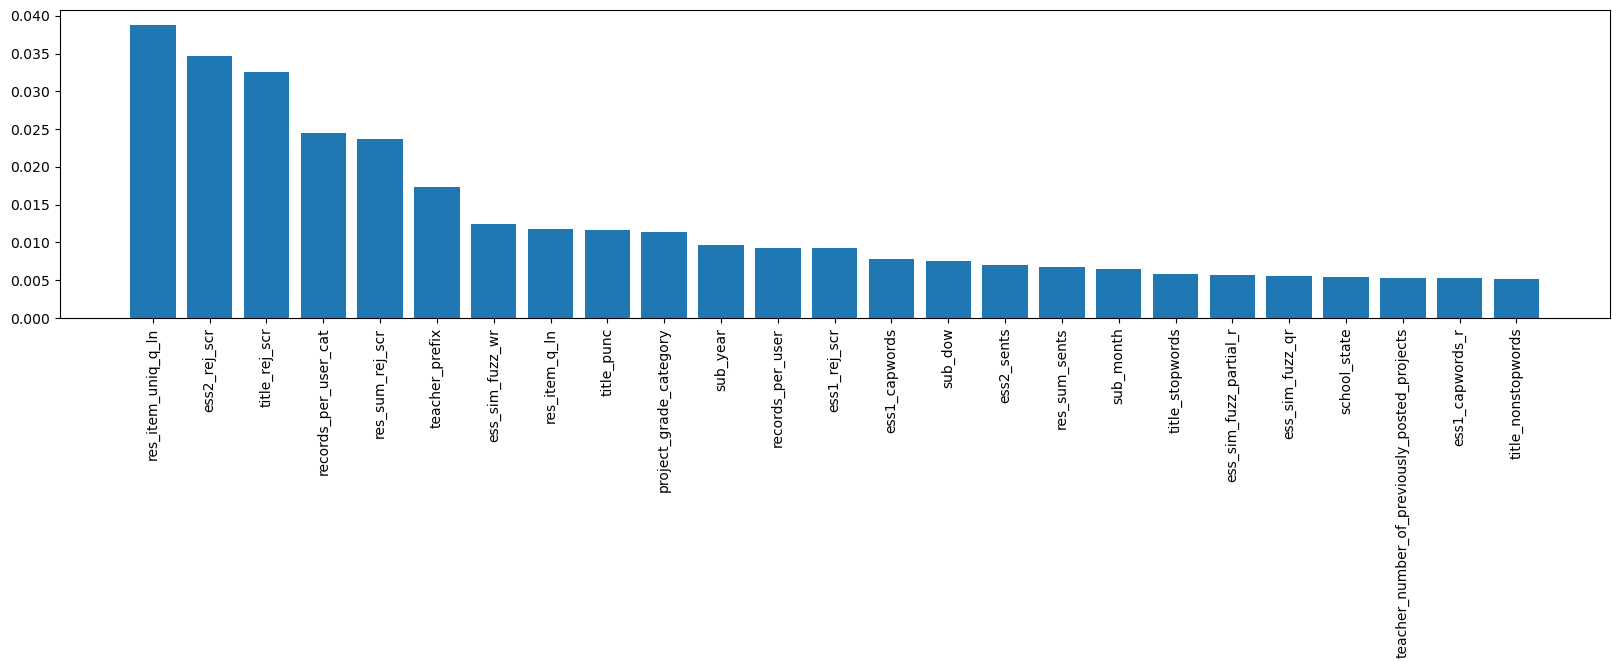

In [108]:
iter11_metrics_arr = get_classification_report(model=rfc11, 
                                               df_train=X3_train, 
                                               X_train=X3_train_scl_smote, 
                                               y_train=y3_train_smote, 
                                               X_test=X3_test_scl, 
                                               y_test=y3_test)

### **Iteration 12: XGB Classifier**

In [109]:
xgbc12 = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
# get_cross_val_score_summary(model=xgbc12, 
#                             X_train=X3_train_scl_smote, 
#                             y_train=y3_train_smote, 
#                             cv=5, 
#                             scoring='accuracy')

Fitting model completed!
----------------------------------------------------------------------
Classification Report: Model:XGBClassifier
----------------------------------------------------------------------
Train accuracy: 0.9922127365020766
Test accuracy: 0.8382151029748284
ROC-AUC score:  0.7101734242517406
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.43      0.18      0.25      2006
           1       0.87      0.96      0.91     11104

    accuracy                           0.84     13110
   macro avg       0.65      0.57      0.58     13110
weighted avg       0.80      0.84      0.81     13110

--------------------------------------------------
Confusion Matrix on Test Set:
[[  353  1653]
 [  468 10636]]
--------------------------------------------------
Top-10 important features:
records_per_user_cat      0.061453
teacher_prefix            0.043425
title_punc                0.037813
project_grade

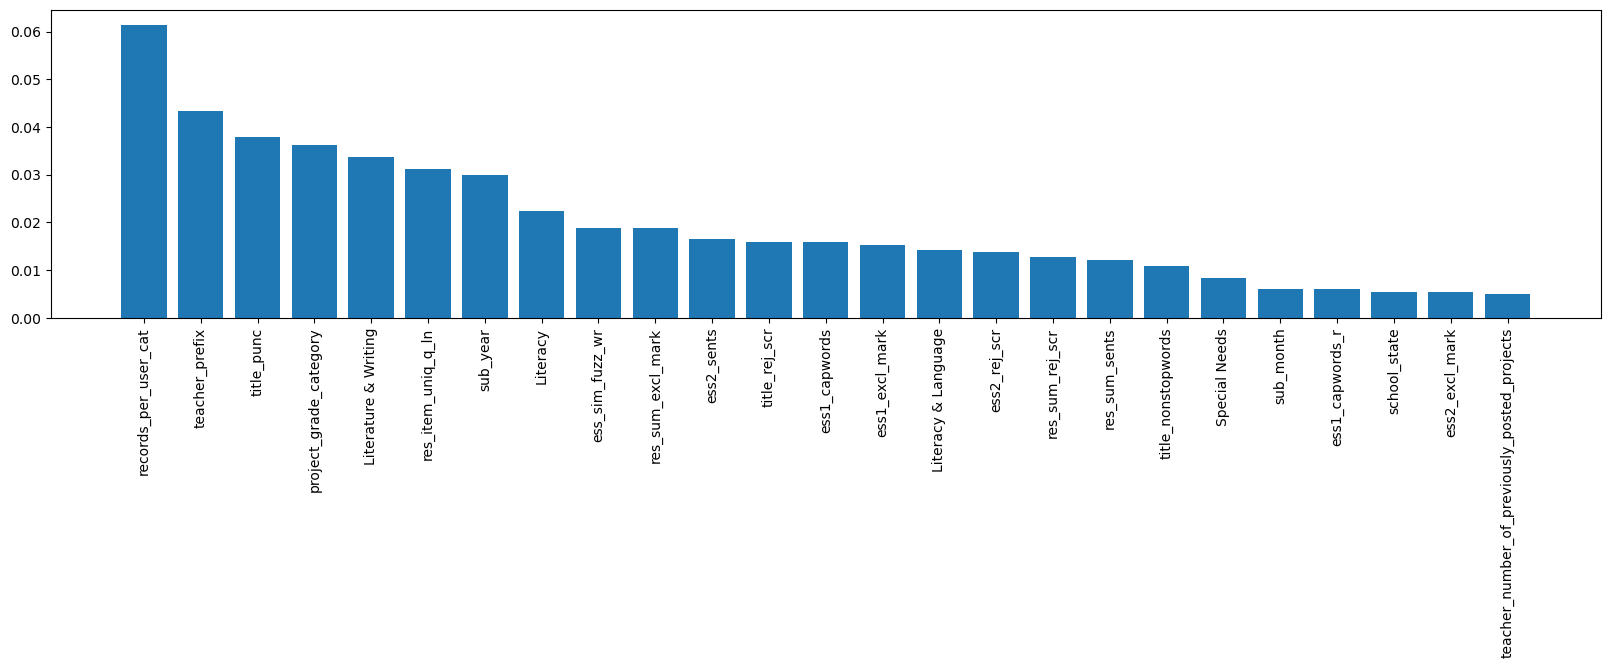

In [110]:
iter12_metrics_arr = get_classification_report(model=xgbc12, 
                                               df_train=X3_train, 
                                               X_train=X3_train_scl_smote, 
                                               y_train=y3_train_smote, 
                                               X_test=X3_test_scl, 
                                               y_test=y3_test)

# **Model Comparison**

In [111]:
df_metrics = pd.DataFrame([iter1_metrics_arr, iter2_metrics_arr, iter3_metrics_arr, iter4_metrics_arr,
                           iter5_metrics_arr, iter6_metrics_arr, iter7_metrics_arr, iter8_metrics_arr,
                           iter9_metrics_arr, iter10_metrics_arr, iter11_metrics_arr, iter12_metrics_arr],
                          columns= ['train_acc', 'test_acc', 'roc_auc', 'prec_0', 'rec_0', 'f1_0', 'prec_1', 'rec_1', 'f1_1'],
                          index=[i for i in range(1, 13)]
                         )



df_metrics['Model'] = ['RF_Classifier', 'XGB_Classifier']*6
df_metrics['Features'] = ['Metadata']*4 + ['Metadata+BasicNLP']*4 + ['Metadata+BasicNLP+w2v']*4
df_metrics['Sample_Size(%)'] = [40]*12
df_metrics['Balanced_Target'] = ['No', 'No', 'Yes', 'Yes']*3
df_metrics['Hyper_Tuned'] = ['No']*12


df1 = df_metrics.iloc[:, -5:] 
df2 = df_metrics.iloc[:, :-5]
df_metrics = pd.concat([df1, df2], axis=1)
df_metrics.reset_index(inplace=True)
df_metrics.rename({'index':'Iteration'}, axis=1, inplace=True)
df_metrics.iloc[:, :9]

,Iteration,Model,Features,Sample_Size(%),Balanced_Target,Hyper_Tuned,train_acc,test_acc,roc_auc
0,1,RF_Classifier,Metadata,40,No,No,1.000000,0.845233,0.667922
1,2,XGB_Classifier,Metadata,40,No,No,0.883909,0.840046,0.668670
2,3,RF_Classifier,Metadata,40,Yes,No,1.000000,0.830892,0.661110
3,4,XGB_Classifier,Metadata,40,Yes,No,0.925723,0.841724,0.675150
4,5,RF_Classifier,Metadata+BasicNLP,40,No,No,1.000000,0.848970,0.714746
5,6,XGB_Classifier,Metadata+BasicNLP,40,No,No,0.944194,0.839588,0.710281
6,7,RF_Classifier,Metadata+BasicNLP,40,Yes,No,1.000000,0.834477,0.721063
7,8,XGB_Classifier,Metadata+BasicNLP,40,Yes,No,0.963467,0.838673,0.704976
8,9,RF_Classifier,Metadata+BasicNLP+w2v,40,No,No,1.000000,0.849352,0.702970
9,10,XGB_Classifier,Metadata+BasicNLP+w2v,40,No,No,0.994835,0.841419,0.716461


In [112]:
df_metrics.loc[df_metrics['Model']=='XGB_Classifier'].iloc[:, :]

,Iteration,Model,Features,Sample_Size(%),Balanced_Target,Hyper_Tuned,train_acc,test_acc,roc_auc,prec_0,rec_0,f1_0,prec_1,rec_1,f1_1
1,2,XGB_Classifier,Metadata,40,No,No,0.883909,0.840046,0.668670,0.329588,0.043868,0.077431,0.850658,0.983880,0.912432
3,4,XGB_Classifier,Metadata,40,Yes,No,0.925723,0.841724,0.675150,0.345291,0.038385,0.069089,0.850314,0.986852,0.913509
5,6,XGB_Classifier,Metadata+BasicNLP,40,No,No,0.944194,0.839588,0.710281,0.438059,0.170987,0.245966,0.865093,0.960375,0.910247
7,8,XGB_Classifier,Metadata+BasicNLP,40,Yes,No,0.963467,0.838673,0.704976,0.434416,0.179960,0.254494,0.866031,0.957673,0.909550
9,10,XGB_Classifier,Metadata+BasicNLP+w2v,40,No,No,0.994835,0.841419,0.716461,0.448664,0.159023,0.234818,0.863941,0.964697,0.911543
11,12,XGB_Classifier,Metadata+BasicNLP+w2v,40,Yes,No,0.992213,0.838215,0.710173,0.429963,0.175972,0.249735,0.865489,0.957853,0.909332


In [113]:
# df_metrics.to_csv('./model_evaluation/model_comparison_v1.csv', sep=',', index=False)